# Back-Propagation with UCLA Student Admission Data

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as pre
from sklearn import model_selection

sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=1))

In [37]:
data = pd.read_csv('student_data.csv')
data.head(10)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


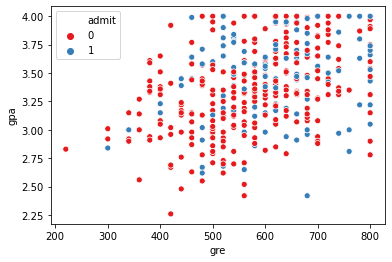

In [38]:
sns.scatterplot(x='gre', y='gpa', hue='admit', data=data)

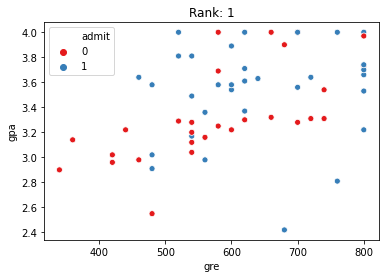

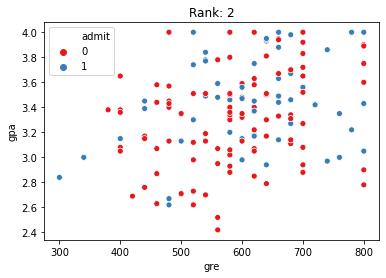

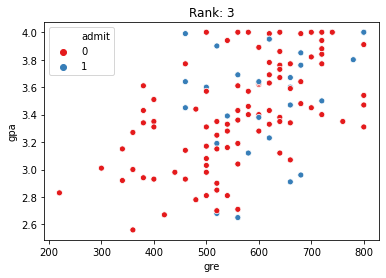

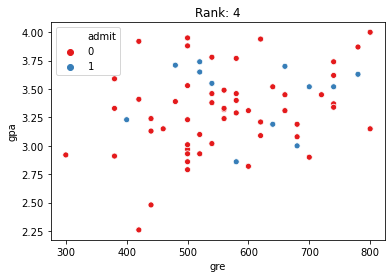

In [39]:
ranks = np.sort(data['rank'].unique())
for r in ranks:
    plt.title(f'Rank: {r}')
    sns.scatterplot(x='gre', y='gpa', hue='admit', data=data[data['rank'] == r])
    plt.show()

### One-hot encode rank data:
Let's use Pandas `get_dummies` function:

In [40]:
one_hot_rank = pd.get_dummies(data.loc[:,'rank'])
data = data.drop(['rank'], axis=1)
data = pd.concat([data, one_hot_rank], axis=1)
data.head(10)

,admit,gre,gpa,1,2,3,4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


### Scale Data to range [0,1]:
Neural networks like data that is scaled

In [44]:
data_copy = data.loc[:]
scaled_data = pre.minmax_scale(data, feature_range=(0,1))
scaled_data[:10]


array([[0.        , 0.27586207, 0.77586207, 0.        , 0.        ,
        1.        , 0.        ],
       [1.        , 0.75862069, 0.81034483, 0.        , 0.        ,
        1.        , 0.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.72413793, 0.53448276, 0.        , 0.        ,
        0.        , 1.        ],
       [0.        , 0.51724138, 0.38505747, 0.        , 0.        ,
        0.        , 1.        ],
       [1.        , 0.93103448, 0.42528736, 0.        , 1.        ,
        0.        , 0.        ],
       [1.        , 0.5862069 , 0.4137931 , 1.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.31034483, 0.47126437, 0.        , 1.        ,
        0.        , 0.        ],
       [1.        , 0.55172414, 0.64942529, 0.        , 0.        ,
        1.        , 0.        ],
       [0.        , 0.82758621, 0.95402299, 0.        , 1.        ,
        0.        , 0. 

### Split data into features and labels, test and training:

In [50]:
X = scaled_data[:,1:]
y = scaled_data[:,0]
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=.1)
print(f'Number of training samples is {len(x_train)}')

Number of training samples is 360


### Define gradient descent functions:

In [65]:
def sigmoid(X): 
    return 1 / (1 + np.exp(-X))

def sigmoid_prime(X):
    return sigmoid(X) * (1 - sigmoid(X))

def probability(X, weights, bias):
    return sigmoid(np.dot(X, weights) + bias)

def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

def dEdy(X, y, output):
    return (y - output) * sigmoid_prime(X)

def cross_entropy_ave(y, y_hat):
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

In [66]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.5

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)
    print(f'weight matrix shape {weights.shape}')

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights)) #sigmoid(np.dot(weights2, sigmoid(np.dot(weights1, x)))) = y_hat

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = dEdy(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(x_train, y_train, epochs, learnrate)

weight matrix shape (6,)
Epoch: 0
Train loss:  0.27822525314476726
Epoch: 100
Train loss:  0.2145240732550317
Epoch: 200
Train loss:  0.2118007535714243
Epoch: 300
Train loss:  0.21016596457300674
Epoch: 400
Train loss:  0.2090097005498399
Epoch: 500
Train loss:  0.20810228152098773
Epoch: 600
Train loss:  0.2073321561863338
Epoch: 700
Train loss:  0.206644706109989
Epoch: 800
Train loss:  0.2060125445958217
Epoch: 900
Train loss:  0.2054214722323833
Finished training!


In [67]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(x_test, weights))
predictions = test_out >= 0.5
accuracy = np.mean(predictions == y_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.725
